/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691:

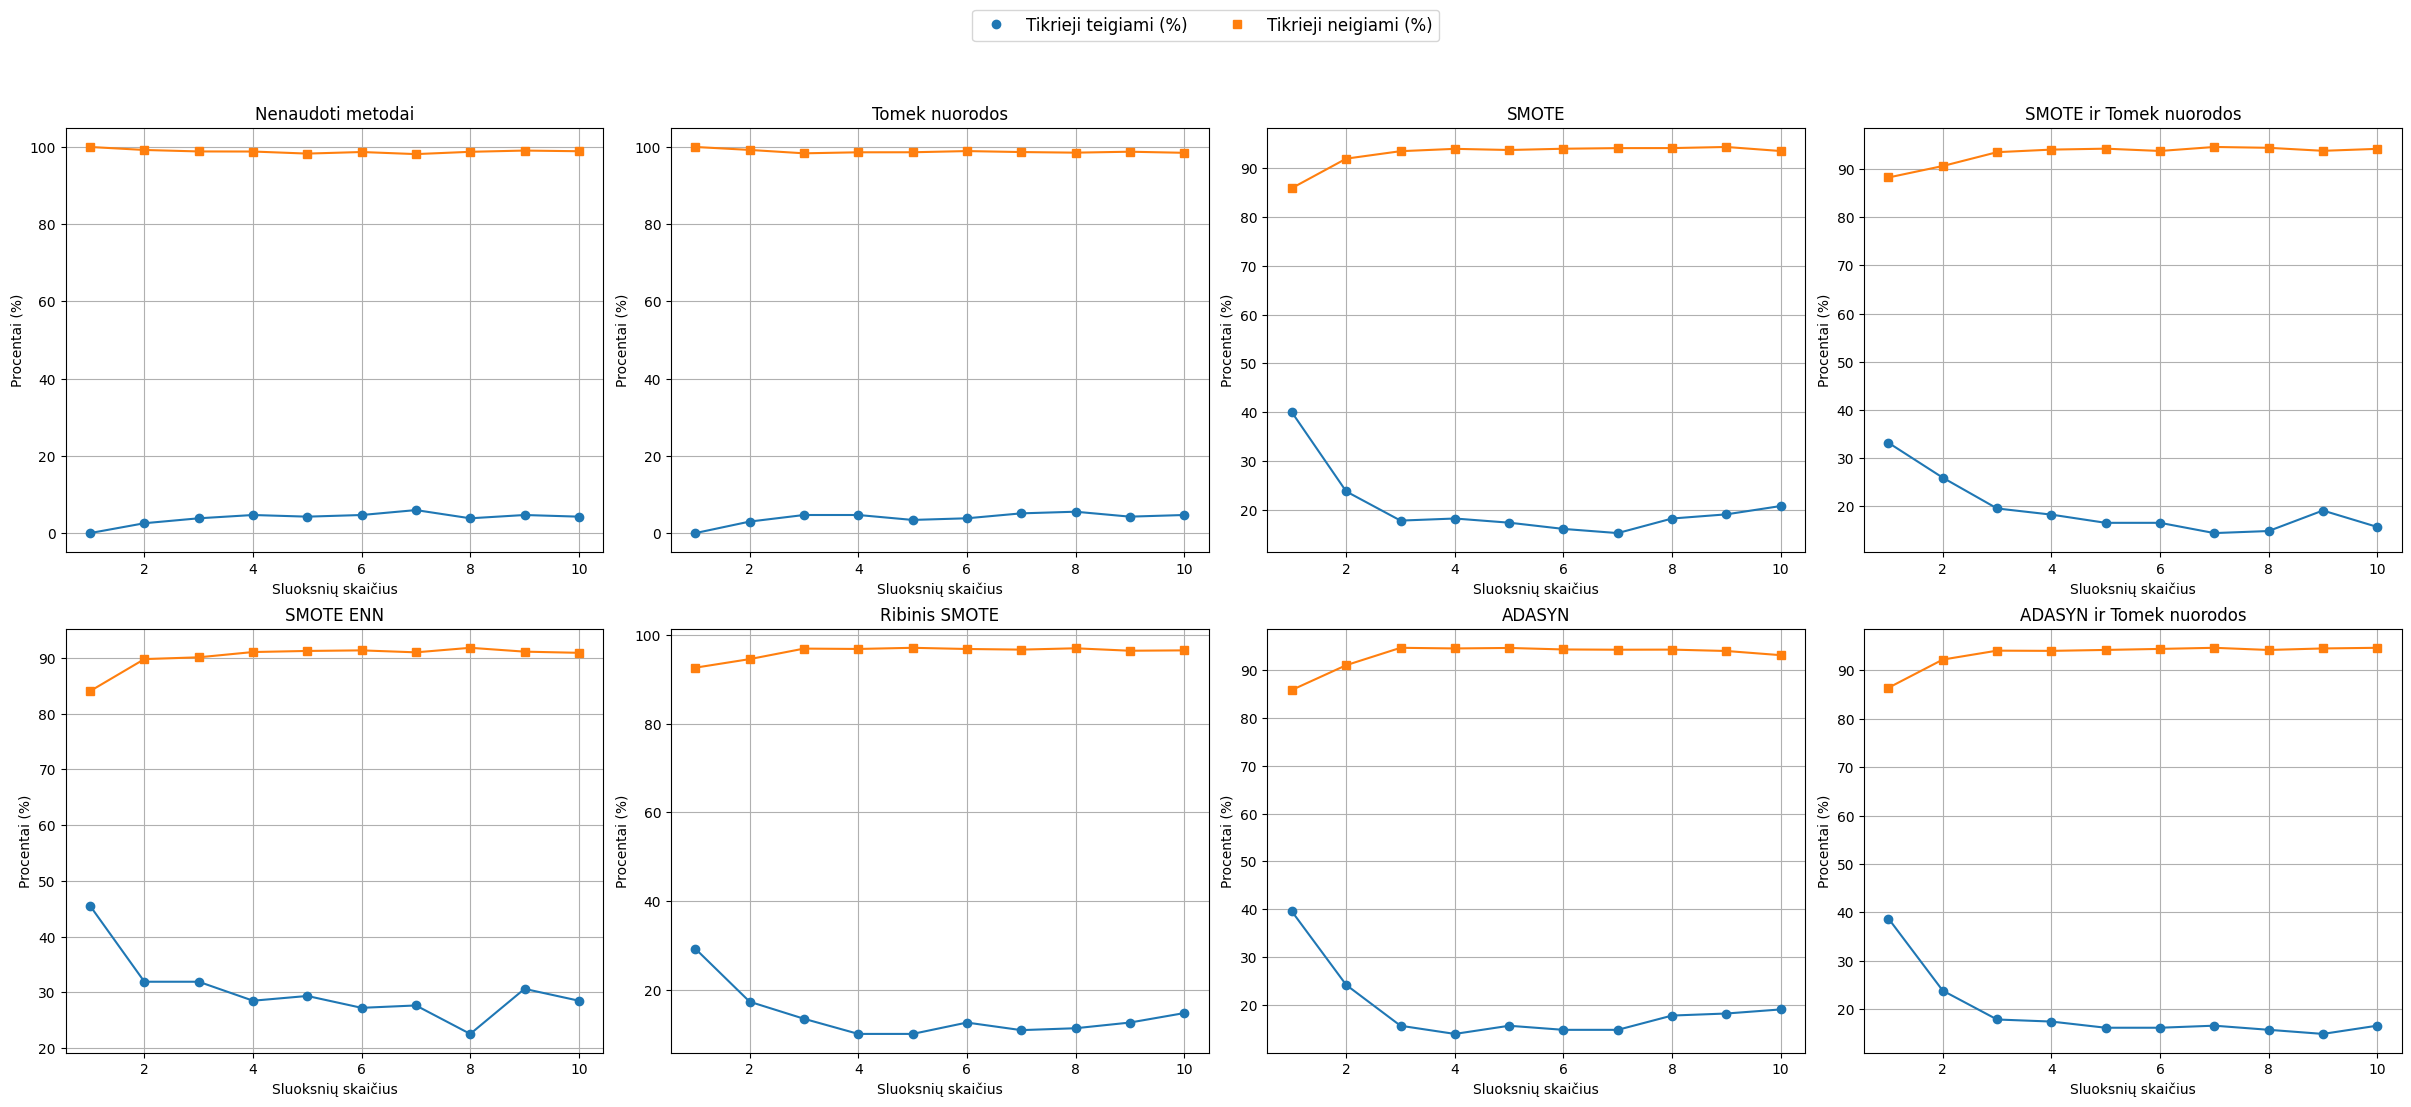

/var/folders/xn/wjzsc54j30q1_1ylc9gg8vth0000gn/T/ipykernel_51909/3769807920.py:134: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig2.subplots_adjust(top=0.88)


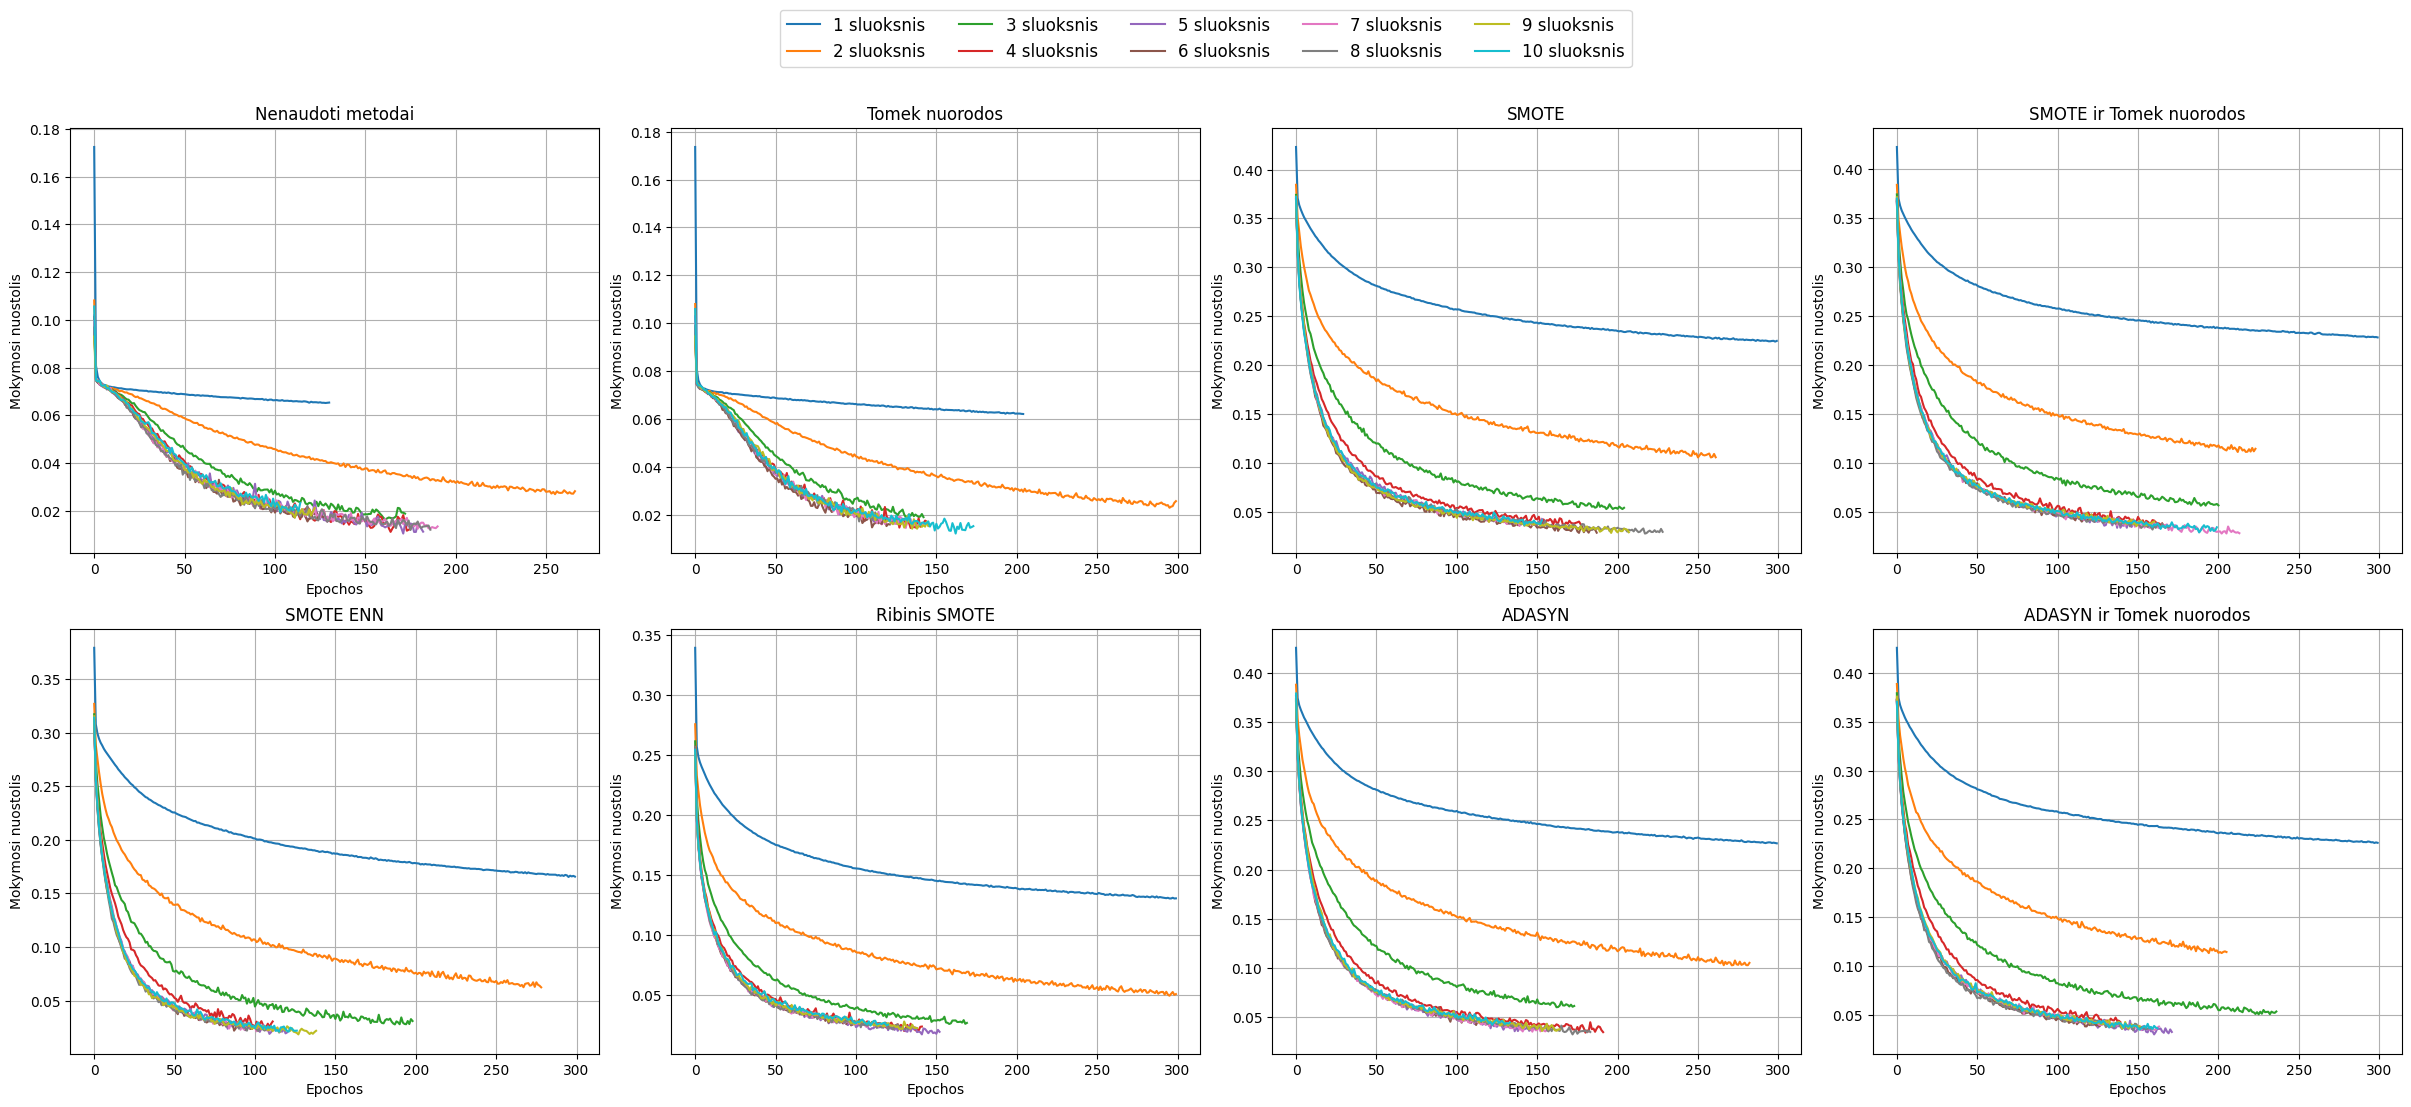

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTEENN
from matplotlib.lines import Line2D


# Load dataset
df = pd.read_csv('dataset_original.csv', encoding='utf-8-sig')
df.drop(columns=['id'], inplace=Tr
ue)

# Impute missing values
df['KMI'] = SimpleImputer(strategy='mean').fit_transform(df[['KMI']])
df['Rūkymo statusas'] = SimpleImputer(strategy='most_frequent').fit_transform(df[['Rūkymo statusas']]).ravel()

# Encode categorical columns
categorical_cols = ['Lytis', 'Gyvenamosios vietos tipas', 'Kažkada susituokęs', 'Rūkymo statusas', 'Darbo tipas']
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Split features and target
X = df.drop(columns=['Insultas'])
y = df['Insultas']

# Define sampling methods
methods = [
    (None, "Nenaudoti metodai"),
    (TomekLinks(), "Tomek nuorodos"),
    (SMOTE(sampling_strategy=0.99, random_state=7), "SMOTE"),
    ((SMOTE(sampling_strategy=0.99, random_state=7), TomekLinks()), "SMOTE ir Tomek nuorodos"),
    (SMOTEENN(sampling_strategy=0.99, random_state=7), "SMOTE ENN"),
    (BorderlineSMOTE(sampling_strategy=0.99, random_state=7), "Ribinis SMOTE"),
    (ADASYN(sampling_strategy=0.99, random_state=7), "ADASYN"),
    ((ADASYN(sampling_strategy=0.99, random_state=7), TomekLinks()), "ADASYN ir Tomek nuorodos"),
]

# Results containers
tp_results, tn_results, loss_results = [], [], []
titles = []

for sampler, title in methods:
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=7, stratify=y
    )

    # Apply sampling
    if sampler is None:
        X_res, y_res = X_train, y_train
    elif isinstance(sampler, tuple):
        X_res, y_res = sampler[0].fit_resample(X_train, y_train)
        X_res, y_res = sampler[1].fit_resample(X_res, y_res)
    else:
        X_res, y_res = sampler.fit_resample(X_train, y_train)

    # Scale
    scaler = StandardScaler()
    X_res = scaler.fit_transform(X_res)
    X_test_scaled = scaler.transform(X_test)

    tp_list, tn_list, loss_list = [], [], []
    for layer_count in range(1, 11):
        mlp = MLPClassifier(hidden_layer_sizes=(150,) * layer_count, max_iter=300, random_state=7)
        mlp.fit(X_res, y_res)
        preds = mlp.predict(X_test_scaled)

        cm = confusion_matrix(y_test, preds)
        cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

        tp_list.append(cm_pct[1, 1])
        tn_list.append(cm_pct[0, 0])
        loss_list.append(mlp.loss_curve_)

    tp_results.append(tp_list)
    tn_results.append(tn_list)
    loss_results.append(loss_list)
    titles.append(title)


# Plot 1: TP and TN across layers
fig, axes = plt.subplots(2, 4, figsize=(24, 10), constrained_layout=True)
axes = axes.flatten()
layer_counts = list(range(1, 11))

for i in range(8):
    axes[i].plot(layer_counts, tp_results[i], marker='o', color='C0')
    axes[i].plot(layer_counts, tn_results[i], marker='s', color='C1')
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Sluoksnių skaičius')
    axes[i].set_ylabel('Procentai (%)')
    axes[i].grid(True)

proxy_lines = [
    Line2D([0], [0], marker='o', color='C0', label='Tikrieji teigiami (%)', linestyle=''),
    Line2D([0], [0], marker='s', color='C1', label='Tikrieji neigiami (%)', linestyle='')
]
fig.legend(handles=proxy_lines,
           loc='upper center',
           bbox_to_anchor=(0.5, 1.10),
           ncol=2,
           fontsize=12)
fig.subplots_adjust(top=0.88)
#plt.savefig("stroke_all_methods_layers_150.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Training Loss across layers
fig2, axes2 = plt.subplots(2, 4, figsize=(24, 10), constrained_layout=True)
axes2 = axes2.flatten()

for i in range(8):
    for L, lc in enumerate(loss_results[i], start=1):
        axes2[i].plot(lc, color=f'C{(L-1)%10}')
    axes2[i].set_title(titles[i])
    axes2[i].set_xlabel('Epochos')
    axes2[i].set_ylabel('Mokymosi nuostolis')
    axes2[i].grid(True)

loss_proxies = [
    Line2D([0], [0], color=f'C{(L-1)%10}', label=f'{L} sluoksnis')
    for L in layer_counts
]
fig2.legend(handles=loss_proxies,
            loc='upper center',
            bbox_to_anchor=(0.5, 1.10),
            ncol=5,
            fontsize=12)
fig2.subplots_adjust(top=0.88)
#plt.savefig("stroke_all_methods_epoch_150.png", dpi=300, bbox_inches='tight')
plt.show()


/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691:

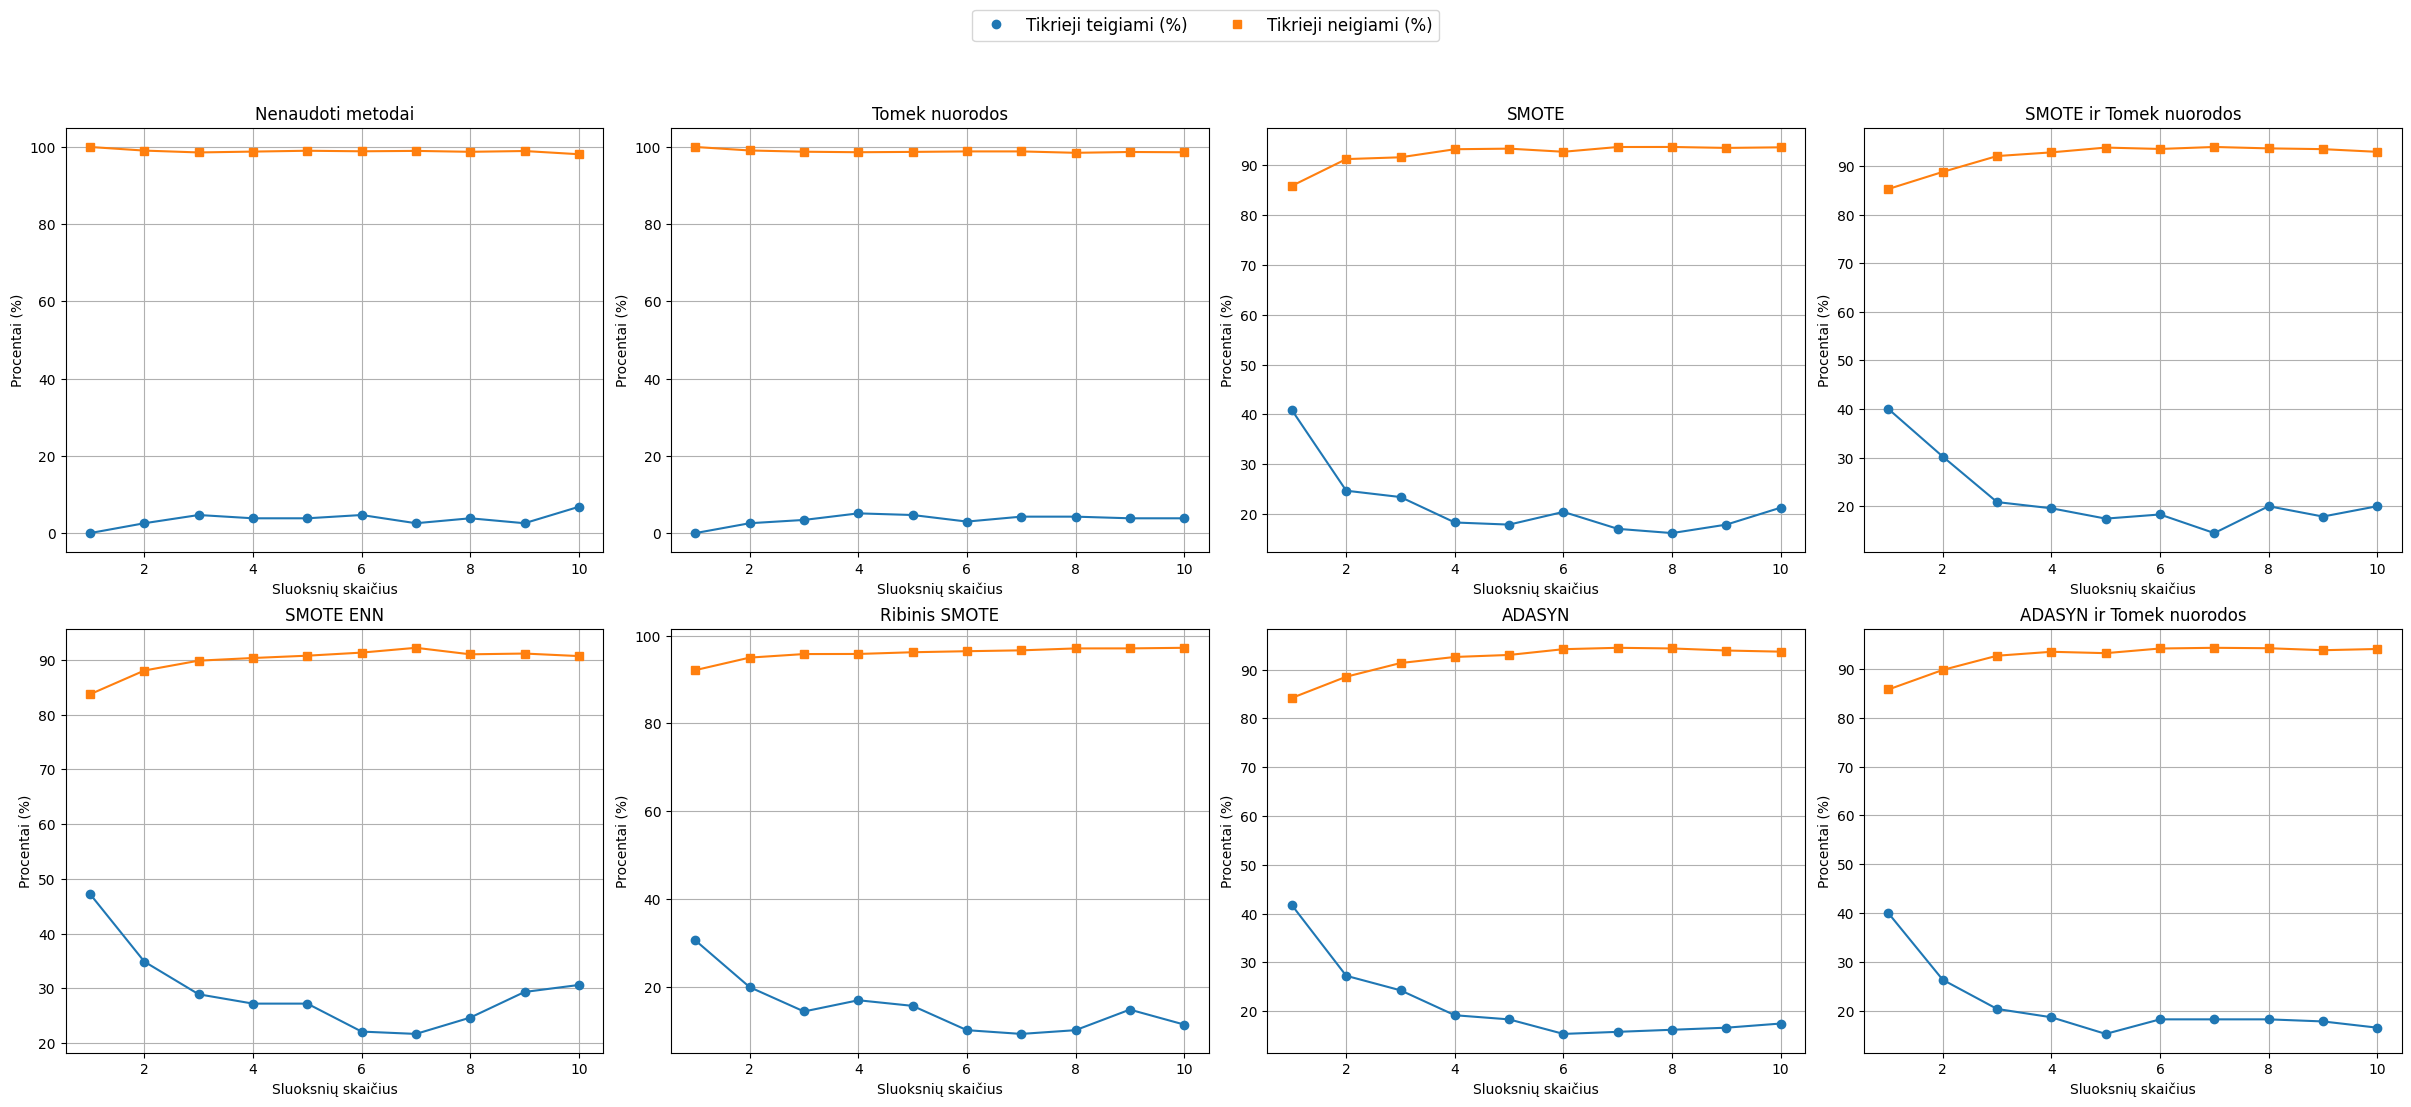

/var/folders/xn/wjzsc54j30q1_1ylc9gg8vth0000gn/T/ipykernel_51909/1015159210.py:134: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig2.subplots_adjust(top=0.88)


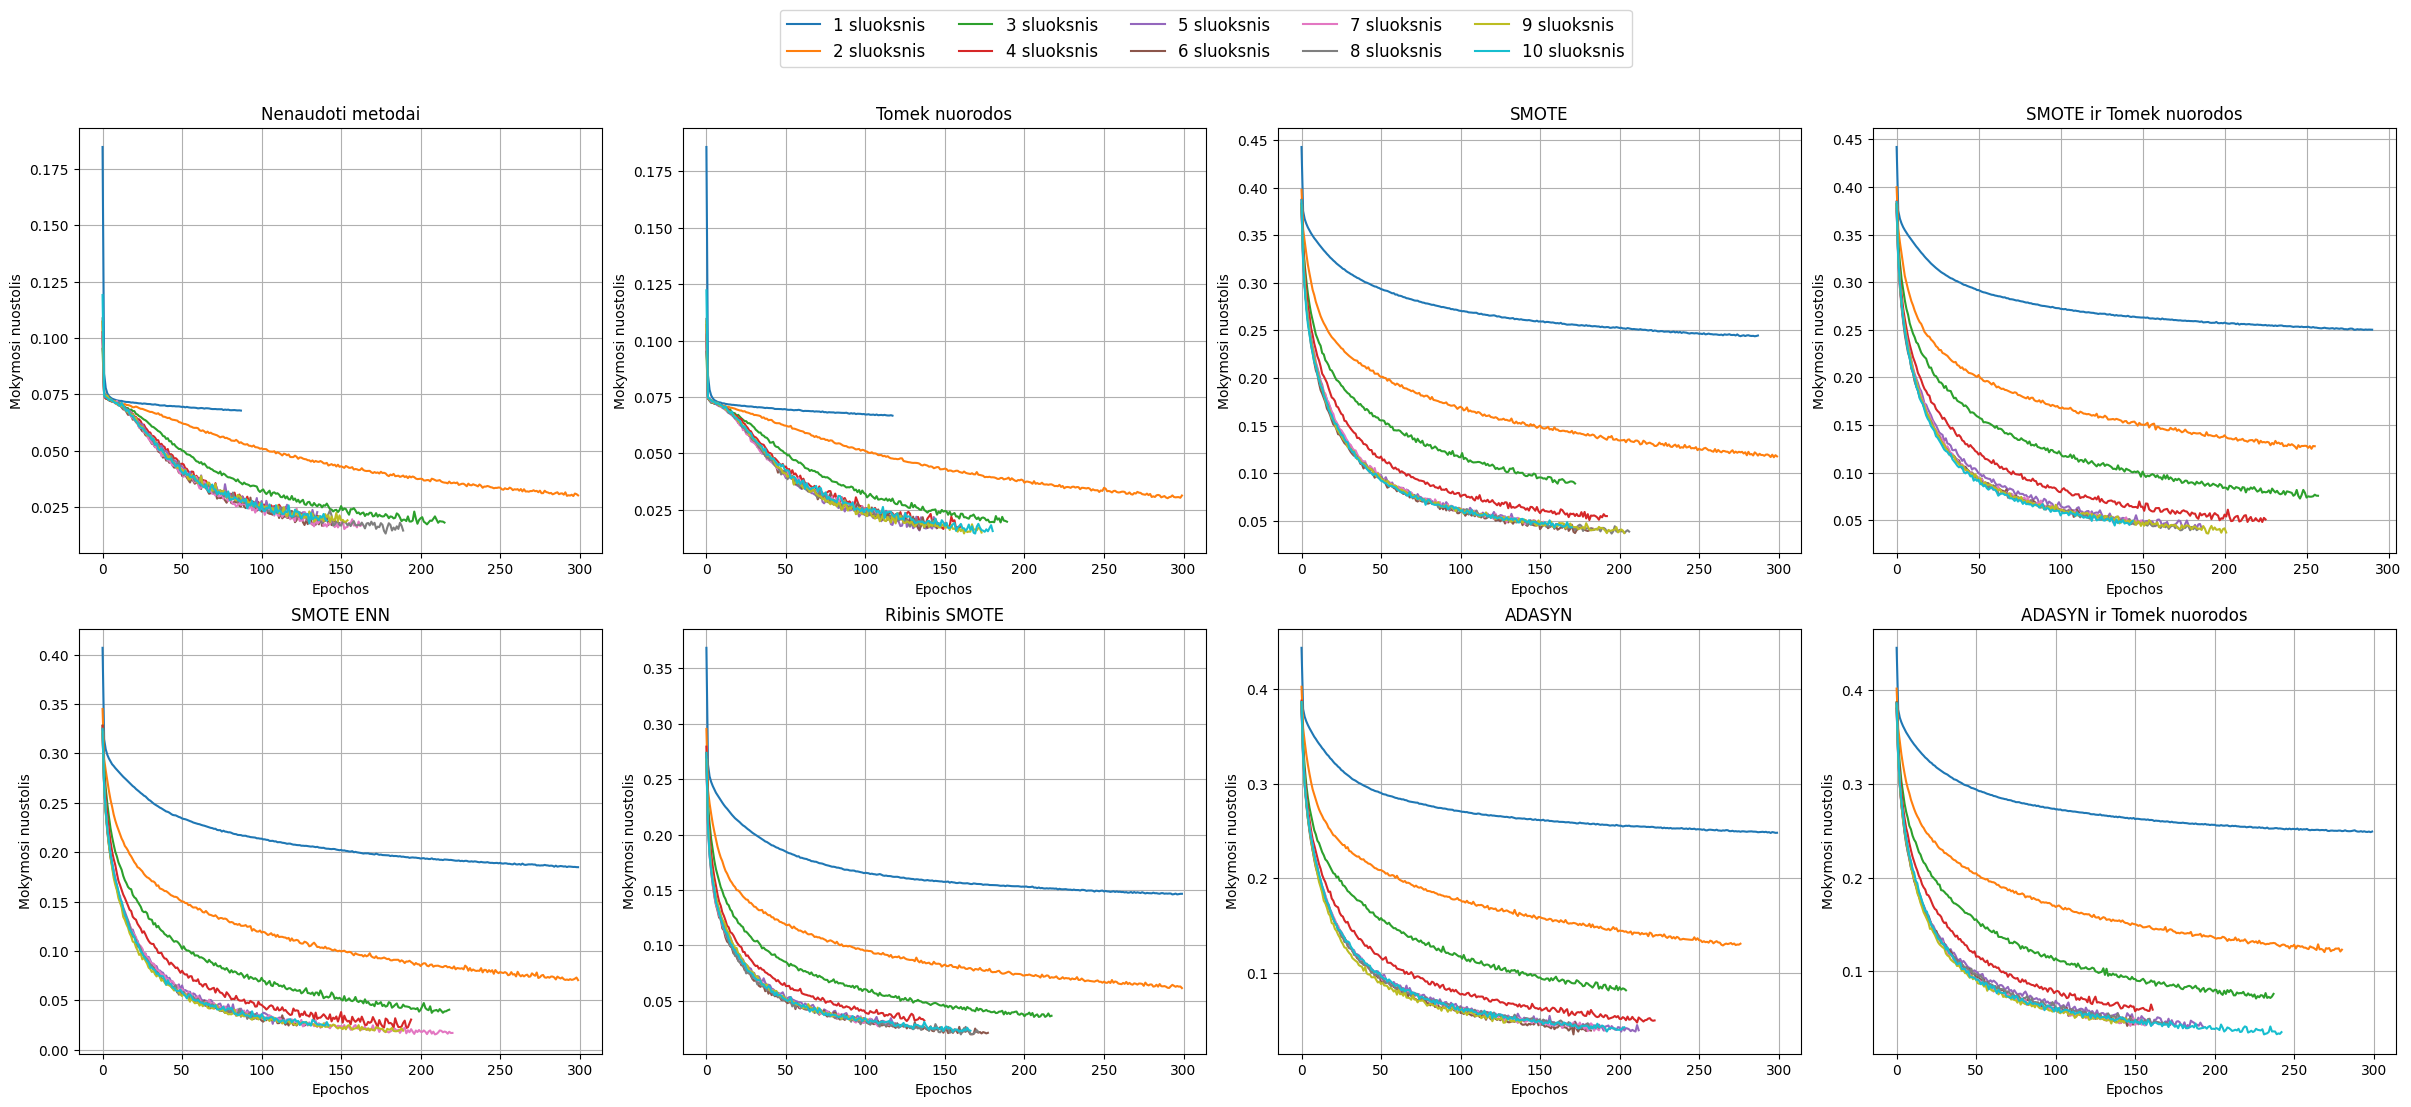

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTEENN
from matplotlib.lines import Line2D


# Load dataset
df = pd.read_csv('dataset_original.csv', encoding='utf-8-sig')
df.drop(columns=['id'], inplace=True)

# Impute missing values
df['KMI'] = SimpleImputer(strategy='mean').fit_transform(df[['KMI']])
df['Rūkymo statusas'] = SimpleImputer(strategy='most_frequent').fit_transform(df[['Rūkymo statusas']]).ravel()

# Encode categorical columns
categorical_cols = ['Lytis', 'Gyvenamosios vietos tipas', 'Kažkada susituokęs', 'Rūkymo statusas', 'Darbo tipas']
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Split features and target
X = df.drop(columns=['Insultas'])
y = df['Insultas']

# Define sampling methods
methods = [
    (None, "Nenaudoti metodai"),
    (TomekLinks(), "Tomek nuorodos"),
    (SMOTE(sampling_strategy=0.99, random_state=7), "SMOTE"),
    ((SMOTE(sampling_strategy=0.99, random_state=7), TomekLinks()), "SMOTE ir Tomek nuorodos"),
    (SMOTEENN(sampling_strategy=0.99, random_state=7), "SMOTE ENN"),
    (BorderlineSMOTE(sampling_strategy=0.99, random_state=7), "Ribinis SMOTE"),
    (ADASYN(sampling_strategy=0.99, random_state=7), "ADASYN"),
    ((ADASYN(sampling_strategy=0.99, random_state=7), TomekLinks()), "ADASYN ir Tomek nuorodos"),
]

# Results containers
tp_results, tn_results, loss_results = [], [], []
titles = []

for sampler, title in methods:
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=7, stratify=y
    )

    # Apply sampling
    if sampler is None:
        X_res, y_res = X_train, y_train
    elif isinstance(sampler, tuple):
        X_res, y_res = sampler[0].fit_resample(X_train, y_train)
        X_res, y_res = sampler[1].fit_resample(X_res, y_res)
    else:
        X_res, y_res = sampler.fit_resample(X_train, y_train)

    # Scale
    scaler = StandardScaler()
    X_res = scaler.fit_transform(X_res)
    X_test_scaled = scaler.transform(X_test)

    tp_list, tn_list, loss_list = [], [], []
    for layer_count in range(1, 11):
        mlp = MLPClassifier(hidden_layer_sizes=(100,) * layer_count, max_iter=300, random_state=7)
        mlp.fit(X_res, y_res)
        preds = mlp.predict(X_test_scaled)

        cm = confusion_matrix(y_test, preds)
        cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

        tp_list.append(cm_pct[1, 1])
        tn_list.append(cm_pct[0, 0])
        loss_list.append(mlp.loss_curve_)

    tp_results.append(tp_list)
    tn_results.append(tn_list)
    loss_results.append(loss_list)
    titles.append(title)


# Plot 1: TP and TN across layers
fig, axes = plt.subplots(2, 4, figsize=(24, 10), constrained_layout=True)
axes = axes.flatten()
layer_counts = list(range(1, 11))

for i in range(8):
    axes[i].plot(layer_counts, tp_results[i], marker='o', color='C0')
    axes[i].plot(layer_counts, tn_results[i], marker='s', color='C1')
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Sluoksnių skaičius')
    axes[i].set_ylabel('Procentai (%)')
    axes[i].grid(True)

proxy_lines = [
    Line2D([0], [0], marker='o', color='C0', label='Tikrieji teigiami (%)', linestyle=''),
    Line2D([0], [0], marker='s', color='C1', label='Tikrieji neigiami (%)', linestyle='')
]
fig.legend(handles=proxy_lines,
           loc='upper center',
           bbox_to_anchor=(0.5, 1.10),
           ncol=2,
           fontsize=12)
fig.subplots_adjust(top=0.88)
#plt.savefig("stroke_all_methods_layers_150.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Training Loss across layers
fig2, axes2 = plt.subplots(2, 4, figsize=(24, 10), constrained_layout=True)
axes2 = axes2.flatten()

for i in range(8):
    for L, lc in enumerate(loss_results[i], start=1):
        axes2[i].plot(lc, color=f'C{(L-1)%10}')
    axes2[i].set_title(titles[i])
    axes2[i].set_xlabel('Epochos')
    axes2[i].set_ylabel('Mokymosi nuostolis')
    axes2[i].grid(True)

loss_proxies = [
    Line2D([0], [0], color=f'C{(L-1)%10}', label=f'{L} sluoksnis')
    for L in layer_counts
]
fig2.legend(handles=loss_proxies,
            loc='upper center',
            bbox_to_anchor=(0.5, 1.10),
            ncol=5,
            fontsize=12)
fig2.subplots_adjust(top=0.88)
#plt.savefig("stroke_all_methods_epoch_150.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTEENN
from matplotlib.lines import Line2D


# Load dataset
df = pd.read_csv('dataset_original.csv', encoding='utf-8-sig')
df.drop(columns=['id'], inplace=True)

# Impute missing values
df['KMI'] = SimpleImputer(strategy='mean').fit_transform(df[['KMI']])
df['Rūkymo statusas'] = SimpleImputer(strategy='most_frequent').fit_transform(df[['Rūkymo statusas']]).ravel()

# Encode categorical columns
categorical_cols = ['Lytis', 'Gyvenamosios vietos tipas', 'Kažkada susituokęs', 'Rūkymo statusas', 'Darbo tipas']
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Split features and target
X = df.drop(columns=['Insultas'])
y = df['Insultas']

# Define sampling methods
methods = [
    (None, "Nenaudoti metodai"),
    (TomekLinks(), "Tomek nuorodos"),
    (SMOTE(sampling_strategy=0.99, random_state=7), "SMOTE"),
    ((SMOTE(sampling_strategy=0.99, random_state=7), TomekLinks()), "SMOTE ir Tomek nuorodos"),
    (SMOTEENN(sampling_strategy=0.99, random_state=7), "SMOTE ENN"),
    (BorderlineSMOTE(sampling_strategy=0.99, random_state=7), "Ribinis SMOTE"),
    (ADASYN(sampling_strategy=0.99, random_state=7), "ADASYN"),
    ((ADASYN(sampling_strategy=0.99, random_state=7), TomekLinks()), "ADASYN ir Tomek nuorodos"),
]

# Results containers
tp_results, tn_results, loss_results = [], [], []
titles = []

for sampler, title in methods:
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=7, stratify=y
    )

    # Apply sampling
    if sampler is None:
        X_res, y_res = X_train, y_train
    elif isinstance(sampler, tuple):
        X_res, y_res = sampler[0].fit_resample(X_train, y_train)
        X_res, y_res = sampler[1].fit_resample(X_res, y_res)
    else:
        X_res, y_res = sampler.fit_resample(X_train, y_train)

    # Scale
    scaler = StandardScaler()
    X_res = scaler.fit_transform(X_res)
    X_test_scaled = scaler.transform(X_test)

    tp_list, tn_list, loss_list = [], [], []
    for layer_count in range(1, 11):
        mlp = MLPClassifier(hidden_layer_sizes=(50,) * layer_count, max_iter=300, random_state=7)
        mlp.fit(X_res, y_res)
        preds = mlp.predict(X_test_scaled)

        cm = confusion_matrix(y_test, preds)
        cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

        tp_list.append(cm_pct[1, 1])
        tn_list.append(cm_pct[0, 0])
        loss_list.append(mlp.loss_curve_)

    tp_results.append(tp_list)
    tn_results.append(tn_list)
    loss_results.append(loss_list)
    titles.append(title)


# Plot 1: TP and TN across layers
fig, axes = plt.subplots(2, 4, figsize=(24, 10), constrained_layout=True)
axes = axes.flatten()
layer_counts = list(range(1, 11))

for i in range(8):
    axes[i].plot(layer_counts, tp_results[i], marker='o', color='C0')
    axes[i].plot(layer_counts, tn_results[i], marker='s', color='C1')
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Sluoksnių skaičius')
    axes[i].set_ylabel('Procentai (%)')
    axes[i].grid(True)

proxy_lines = [
    Line2D([0], [0], marker='o', color='C0', label='Tikrieji teigiami (%)', linestyle=''),
    Line2D([0], [0], marker='s', color='C1', label='Tikrieji neigiami (%)', linestyle='')
]
fig.legend(handles=proxy_lines,
           loc='upper center',
           bbox_to_anchor=(0.5, 1.10),
           ncol=2,
           fontsize=12)
fig.subplots_adjust(top=0.88)
#plt.savefig("stroke_all_methods_layers_150.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Training Loss across layers
fig2, axes2 = plt.subplots(2, 4, figsize=(24, 10), constrained_layout=True)
axes2 = axes2.flatten()

for i in range(8):
    for L, lc in enumerate(loss_results[i], start=1):
        axes2[i].plot(lc, color=f'C{(L-1)%10}')
    axes2[i].set_title(titles[i])
    axes2[i].set_xlabel('Epochos')
    axes2[i].set_ylabel('Mokymosi nuostolis')
    axes2[i].grid(True)

loss_proxies = [
    Line2D([0], [0], color=f'C{(L-1)%10}', label=f'{L} sluoksnis')
    for L in layer_counts
]
fig2.legend(handles=loss_proxies,
            loc='upper center',
            bbox_to_anchor=(0.5, 1.10),
            ncol=5,
            fontsize=12)
fig2.subplots_adjust(top=0.88)
#plt.savefig("stroke_all_methods_epoch_150.png", dpi=300, bbox_inches='tight')
plt.show()


/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/augustestriogaite/Downloads/Class_imbalance_MLP-main/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: